# Finetune Visual Object Detection Models Using Pre-trained Sagemaker Models


This notebook introduces finetuning pretrained object detection (OD) models on new dataset. 

Training a model from scratch in general is time-consuming and requires large compute resources. When the training data is small, we cannot expect to train a very performant model. A better alternative is to finetune a pretrained model on the target dataset. AWS Sagemaker provides high-quality pretrained models that were trained on very large datasets. Finetuning these models on new dataset takes only fractional training time compard to training from scratch.

In this notebook, we demonstrate how to use two types of Amazon Sagemaker built-in OD models to finetune on the *[Steel Surface Defect](https://github.com/siddhartamukherjee/NEU-DET-Steel-Surface-Defect-Detection)*  dataset, which is used in this solution. 
* Type 1 (legacy): uses a built-in legacy [Object Detection algorithm](https://docs.aws.amazon.com/sagemaker/latest/dg/object-detection.html) and uses the *Single Shot multibox Detector* (SSD) model with either VGG or ResNet backbone, and was pretrained on the ImageNet dataset. 
* Type 2 (latest):  provides [9 pretrained OD models](https://sagemaker.readthedocs.io/en/stable/doc_utils/pretrainedmodels.html?highlight=jumpstart#built-in-algorithms-with-pre-trained-model-table), including 8 SSD models and 1 FasterRCNN model. These models use VGG, ResNet, or MobileNet as backbone, and were pretrained on COCO, VOC, or FPN datasets. 


For each type of model, besides training with default hyperparameters, we also perform hyperparameter tuning (i.e., HPO) using [Sagemaker Automatic Model Tuning (AMT)](https://docs.aws.amazon.com/sagemaker/latest/dg/automatic-model-tuning.html) to train even better model. 

Running the whole notebook takes about 8 hours. The most time-consuming part is running HPO jobs for both types of models. You could choose to run more HPO jobs in parallel in order to reduce running time if there are more EC2 instances available.

---

Content
1. [Data Preparation](#1.-Data-Preparation)
2. [Training: Finetune Type 1 (Legacy) OD Model](#2.-Training:-Finetune-Type-1-(Legacy)-OD-Model)
3. [Training: Finetune Type 1 (Legacy) OD Model with HPO](#3.-Training:-Finetune-Type-1-(Legacy)-OD-model-with-HPO)
4. [Training: Finetune Type 2 (Latest) OD Model](#4.-Training:-Finetune-Type-2-(Latest)-OD-Model)
5. [Training: Finetune Type 2 (Latest) OD Model with HPO](#5.-Training:-Finetune-Type-2-(Latest)-OD-model-with-HPO)
6. [Inference and Model Comparison](#6.-Inference-and-Model-Comparison)
7. [Clean Up the Endpoints](#7.-Clean-Up-the-Endpoints)
8. [Conclusion](#8.-Conclusion)

---

** **ATTENTION** ** 

* Running the notebook end-to-end takes 8~9 hours. We changed some parameter values so that the notebook took much shorter time to finish, at the cost of model trainig non-convergence.
* Please change them back when you want to train till convergence. These parameters include `num_epochs=100` for training all models, and `max_jobs=20`, `max_parallel_jobs=10` for hyperparameter tuning.
* The shown results in this notebook is for fully-convergent models.

---

In [ ]:
num_epochs = 10          # change to 100
max_jobs = 3             # change to 20 or more
max_parallel_jobs = 3    # change to 5 or 10

In [14]:
# Update to latest Sagemaker package to use Sagemaker APIs for model training and deployment
%pip install --upgrade sagemaker
%pip install pycocotools
%pip install opencv-python-headless opencv-python==4.5.5.64 mxnet xmltodict

In [4]:
import os
import sys
import json
import glob
import boto3
import pandas as pd
import matplotlib.pyplot as plt

import sagemaker
from sagemaker import get_execution_role, image_uris, model_uris, script_uris, hyperparameters
from sagemaker.s3 import S3Downloader
from sagemaker.utils import name_from_base
from sagemaker.session import Session
from sagemaker.estimator import Estimator
from sagemaker.analytics import TrainingJobAnalytics
from sagemaker import exceptions
from sagemaker.tuner import (
    HyperparameterTuner,
    ContinuousParameter,
    IntegerParameter,
    CategoricalParameter,
)
from botocore.exceptions import ClientError

# import helper function to convert all xmls to a json file
sys.path.append("./src")
from xml2json import XML2JSON, convert_to_pycocotools_ground_truth

sagemaker_session = sagemaker.Session()
bucket = sagemaker_session.default_bucket()
role = sagemaker.get_execution_role()
region = boto3.Session().region_name

In [15]:
# Download data for preprocessing
solution_bucket = "sagemaker-solutions-prod"
solution_name = "sagemaker-defect-detection/1.4.0"

original_bucket = f"s3://{solution_bucket}-{region}/{solution_name}"
original_data_prefix = "data/NEU-DET.zip"
original_data = f"{original_bucket}/{original_data_prefix}"
print("original data: ")
S3Downloader.list(original_data)

In [16]:
RAW_DATA_PATH = !echo $PWD/raw_neu_det
RAW_DATA_PATH = RAW_DATA_PATH.n
DATA_PATH = !echo $PWD/neu_det
DATA_PATH = DATA_PATH.n

!mkdir -p $RAW_DATA_PATH
!aws s3 cp $original_data $RAW_DATA_PATH
!mkdir -p $DATA_PATH
os.system('unzip -qq {} -d {}'.format(os.path.join(RAW_DATA_PATH, 'NEU-DET.zip'), RAW_DATA_PATH))

# Folders for training data and output artifacts in s3
prefix = name_from_base('defect-detection')
neu_det_s3 = f"s3://{bucket}/{prefix}"
print(neu_det_s3)

s3_input_train = f"{neu_det_s3}/data"
s3_output_location = f"{neu_det_s3}/output"

## 1. Data Preparation

The two types of OD models require different data formats.
The *steel surface dataset* used in this solution contains one xml file for each image as annotation. However, 
neither model uses xml annotations. The Type 1 (legacy) OD model requires either RecordIO or image format in either [*file mode* or *pipe mode*](https://docs.aws.amazon.com/sagemaker/latest/dg/model-access-training-data.html). The Type 2 (latest) OD model requires the input must be a directory with a sub-directory of images and a `annotations.json` file. Please check Section 3 of this [notebook](https://github.com/aws/amazon-sagemaker-examples/blob/main/introduction_to_amazon_algorithms/jumpstart_object_detection/Amazon_JumpStart_Object_Detection.ipynb) for more explanation.

In this notebook, we split the data to be train:val:test = 64:16:20. We allocate 20% data as test data to numerically compare all trained models in the end of the notebook. The steel surface dataset has 1800 images in 6 categories, we randomly allocate 20% images from each category to the test data.

We provide a script to convert the remaining 80% xmls to a single `annotations.json` for training the Type 2 (latest) OD model (under the hood, the source code automatically splits the data to be train:val=80:20, equivalent to 64% of all data as train and 16% as val). We provide another script to convert the `annotations.json` and corresponding images to RecordIO data for the Type 1 (legacy) OD model. 

If your dataset follows the required input format for Type 1 (legacy) or Type 2 (latest) OD model, you do *not* need these conversions. 

In [3]:
# Allocate 20% data for testing different models in the end, convert
# their xmls to test_annotations.json and the remaining 80% to annotations.json

path = "raw_neu_det/NEU-DET/ANNOTATIONS/"
trainXMLFiles = glob.glob(os.path.join(path, "*.xml"))
trainXMLFiles.sort()
XML2JSON(trainXMLFiles, test_ratio=0.2)

In [8]:
# Sync the annotations.json and its corresponding train/val images to s3
os.makedirs("neu_det/images", exist_ok=True)
os.makedirs("results", exist_ok=True)

src_path = "raw_neu_det/NEU-DET/IMAGES"
dst_path = "neu_det/images"

with open("annotations.json") as f:
    images_annotations = json.loads(f.read())

for entry in images_annotations["images"]:
    image_path = os.path.join(src_path, entry["file_name"])
    os.system(f"cp {image_path} {dst_path}")

!mv annotations.json neu_det
!aws s3 sync neu_det $s3_input_train --quiet # remove the --quiet flag to view the sync logs
!aws s3 ls $s3_input_train/

                           PRE images/
2022-09-09 18:51:38     368437 annotations.json


## 2. Training: Finetune Type 1 (Legacy) OD Model


We start from finetuning the Type 1 (legacy) OD model, which is the SSD model with ResNet as backbone, and pretrained on ImageNet. 

**Input data**: follow the [instruction](https://docs.aws.amazon.com/sagemaker/latest/dg/object-detection.html), the legacy OD model supports both RecordIO and image types for training in `file` mode, or RecordIO in `pipe` mode. In this notebook, we use RecordIO in file mode.
We provide a script for converting the `annotations.json` to RecordIO format. The [document](https://cv.gluon.ai/build/examples_datasets/detection_custom.html#lst-label-for-gluoncv-and-mxnet) and [example](https://sagemaker-examples.readthedocs.io/en/latest/introduction_to_amazon_algorithms/object_detection_birds/object_detection_birds.html#Generate-RecordIO-files) provide some context for understanding the script.

This script first splits the data to train:val = 80:20 according to the `train-ratio`. This is equivalent to use 64% of all data for training and 16% for validation. Then converts each partition, including images and annotations, to a .rec file. We use the validation data for selecting the best job in HPO training in the next section, and use the test data for numerically comparing all finetuned models. 

In [13]:
!python ./src/prepare_RecordIO.py ./neu_det/data ./neu_det/images --train-ratio 0.8

In [2]:
# Upload the RecordIO files to train and validation channels in s3

train_channel = f"{prefix}/OD_Type1_train"
validation_channel = f"{prefix}/OD_Type1_validation"

s3_train_data = f"s3://{bucket}/{train_channel}"
s3_validation_data = f"s3://{bucket}/{validation_channel}"
s3_output_location = f"s3://{bucket}/{prefix}/OD_output"

!aws s3 cp neu_det/data_train.rec $s3_train_data/
!aws s3 cp neu_det/data_val.rec $s3_validation_data/
!aws s3 ls $s3_train_data/

train_data = sagemaker.inputs.TrainingInput(
    s3_train_data,
    distribution="FullyReplicated",
    content_type="application/x-recordio",
    s3_data_type="S3Prefix",
)
validation_data = sagemaker.inputs.TrainingInput(
    s3_validation_data,
    distribution="FullyReplicated",
    content_type="application/x-recordio",
    s3_data_type="S3Prefix",
)

data_channels = {"train": train_data, "validation": validation_data}

In [12]:
# Train Type 1 (legacy) OD model
job_name_prefix = "od-Type1"


num_classes = 6
num_training_samples = 1152  # total 1800 images, use 64% for training

train_image_uri = image_uris.retrieve(
    region=sagemaker_session.boto_region_name, framework="object-detection", version="latest"
)

print("Train Type 1 (legacy) OD model -------------------")

# In case one type of EC2 instance is not available and fails the training, try another EC2 instance type.
# This built-in OD algorithm only accepts GPU instances for training.
for instance in ["ml.p3.2xlarge", "ml.g4dn.xlarge", "ml.g5.2xlarge"]:
    try:
        od_model = Estimator(
            train_image_uri,
            role,
            instance_count=1,
            instance_type=instance,
            volume_size=50,
            max_run=360000,
            input_mode="File",
            output_path=s3_output_location,
            sagemaker_session=sagemaker_session,
            base_job_name=job_name_prefix,
        )

        od_model.set_hyperparameters(
            base_network="resnet-50",
            use_pretrained_model=1,
            num_classes=num_classes,
            mini_batch_size=16,
            epochs=num_epochs,
            learning_rate=0.001,
            momentum=0.9,
            weight_decay=0.0005,
            lr_scheduler_step="33,67",
            lr_scheduler_factor=0.1,
            optimizer="sgd",
            overlap_threshold=0.5,
            nms_threshold=0.45,
            num_training_samples=num_training_samples,
        )

        model = od_model.fit(inputs=data_channels, logs="All")

    except exceptions.CapacityError as e:
        print("Training Exception:", e)
        print(f"{instance} is not available !!")
        continue
    except exceptions.UnexpectedStatusException as e:
        print("Training Exception:", e)
        continue
    except ClientError as e:
        print("Training Exception:", e)
        continue
    else:
        print(f"Instance {instance} is available !")
        break

### Visualize Training Progress

During training, the loss function is the sum of CrossEntropy loss and SmoothL1 loss. We visualize the two losses on the training data as well as the mean Average Precision (mAP) on the validation data.

In [2]:
job_name = od_model.latest_training_job.job_name
df = TrainingJobAnalytics(job_name).dataframe()

OD_Type1_metrics = list(set(df.metric_name.values))
print("All metrics:", OD_Type1_metrics)
num_metrics = len(OD_Type1_metrics)

# The train:progress shows the N training epochs, use it to index x axis
epochs = df[df["metric_name"] == "train:progress"]["value"].values
df = df[df["metric_name"] != "train:progress"]


plt.figure(figsize=(18, 5))
cnt = 1
for m in OD_Type1_metrics:
    if m != "train:progress":
        d = df[df["metric_name"] == m]

        if m == "validation:mAP":
            v = list(d.value)[-1]
            print(f"Final validation:mAP = {v:.4f}")
        plt.subplot(1, num_metrics - 1, cnt)

        # in case length mismatch
        l1, l2 = len(epochs), len(d["value"])
        l = min(l1, l2)
        plt.plot(epochs[-l:], d["value"][-l:])

        plt.title(m)
        plt.xlabel("epoch")
        plt.ylabel(m)
        cnt += 1
plt.show()

### Deployment

The inference will be deferred to the end of the notebook

In [4]:
od_type1_endpoint_name = name_from_base("od-Type1")
print(od_type1_endpoint_name)
od_type1_predictor = od_model.deploy(
    endpoint_name=od_type1_endpoint_name, initial_instance_count=1, instance_type="ml.m4.xlarge"
)

## 3. Training: Finetune Type 1 (Legacy) OD model with HPO

Now we run HPO to find better hyperparameters which lead to better model. You could find all [finetunable hyperparameters](https://docs.aws.amazon.com/sagemaker/latest/dg/object-detection-tuning.html) for the Type 1 (legacy) OD model. In this notebook, we only finetune learning rate, momentum, and weight decay. 

We use [Sagemaker Automatic Model Tuning](https://docs.aws.amazon.com/sagemaker/latest/dg/automatic-model-tuning.html) (AMT) to run HPO. We need to provide hyperparameter ranges and objective metrics. AMT monitors the log and parses the objective metrics. For object detection, we use mean Average Precision (mAP) on the validation dataset as our metric. mAP is the standard evaluation metric used in the [COCO Challenge](https://cocodataset.org/#detection-eval) for object detection tasks. Here is a nice [blog post](https://jonathan-hui.medium.com/map-mean-average-precision-for-object-detection-45c121a31173) explaining mAP for object detection. 

We run `max_jobs=20` jobs in this HPO. You could run more jobs to find even better hyperparameters, at the cost of more compute resources and training time. This HPO job takes about 1 hour using p3.2xlarge EC2 instance and run `max_parallel_jobs=10` jobs in parallel.

In [4]:
tuning_job_name = "od-Type1-HPO"

hyperparameter_ranges = {
    "learning_rate": ContinuousParameter(1e-4, 1e-2),
    "momentum": ContinuousParameter(0.8, 0.99),
    "weight_decay": ContinuousParameter(1e-4, 1e-3),
}

objective_metric_name = "validation:mAP"

print("Train Type 1 (legacy) OD model with HPO -------------------")

for instance in ["ml.p3.2xlarge", "ml.g4dn.xlarge", "ml.g5.2xlarge"]:
    try:
        od_model = Estimator(
            train_image_uri,
            role,
            instance_count=1,
            instance_type=instance,
            volume_size=50,
            max_run=360000,
            input_mode="File",
            output_path=s3_output_location,
            sagemaker_session=sagemaker_session,
            base_job_name=job_name_prefix,
        )

        od_model.set_hyperparameters(
            base_network="resnet-50",
            use_pretrained_model=1,
            num_classes=num_classes,
            mini_batch_size=16,
            epochs=num_epochs,
            #             learning_rate=0.001,
            #             momentum=0.9,
            #             weight_decay=0.0005,
            lr_scheduler_step="33,67",
            lr_scheduler_factor=0.1,
            optimizer="sgd",
            overlap_threshold=0.5,
            nms_threshold=0.45,
            num_training_samples=num_training_samples,
        )

        tuner = HyperparameterTuner(
            od_model,
            objective_metric_name,
            hyperparameter_ranges,
            objective_type="Maximize",
            max_jobs=max_jobs,           # <-- increase to 20 or more
            max_parallel_jobs=max_parallel_jobs,  # <- increase this number if more EC2 instances are available
            base_tuning_job_name=tuning_job_name,
        )

        tuner.fit(inputs=data_channels, logs="All")

    except exceptions.CapacityError as e:
        print("Training exception:", e)
        print(f"{instance} is not available !!")
        continue
    except exceptions.UnexpectedStatusException as e:
        print("Training exception:", e)
        continue
    except ClientError as e:
        print("Training Exception:", e)
        continue
    else:
        print(f"Instance {instance} is available !")
        break

In [5]:
tuning_job_name = tuner.latest_tuning_job.name
print("tuning_job_name", tuning_job_name)

tuner_analytics = sagemaker.HyperparameterTuningJobAnalytics(tuning_job_name)

full_df = tuner_analytics.dataframe()

if len(full_df) > 0:
    df = full_df[full_df["FinalObjectiveValue"] > -float("inf")]
    if len(df) > 0:
        df = df.sort_values("FinalObjectiveValue", ascending=False)
        # filter out failed jobs.
        df = df[df["TrainingJobStatus"] == "Completed"]
        print(
            f"Number of training jobs completed and with valid objective: {len(df)} / {len(full_df)}"
        )
        print({"lowest": min(df["FinalObjectiveValue"]), "highest": max(df["FinalObjectiveValue"])})
        pd.set_option("display.max_colwidth", None)  # Don't truncate TrainingJobName
    else:
        print("No training jobs have reported valid results yet.")

df

best job: sagemaker-soln-dfd-c-220805-0846-014-f4010610
best job final validation:mAP = 0.694232


All metrics: ['train:progress', 'validation:mAP', 'train:smooth_l1', 'ObjectiveMetric', 'train:cross_entropy']
ObjectiveMetric is exactly the same as validation:mAP


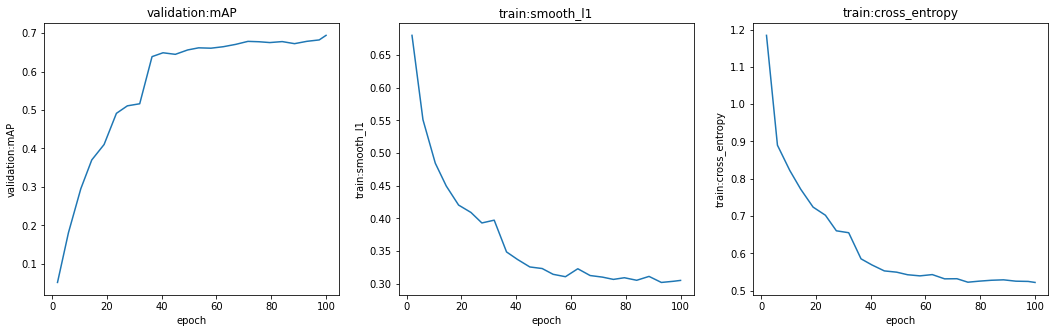

In [13]:
# Visualize the training progress of the best job
best_job_name = df.iloc[0]["TrainingJobName"]
print("best job:", best_job_name)
v = df.iloc[0]["FinalObjectiveValue"]
print(f"best job final validation:mAP = {v:.6f}")

df_best = TrainingJobAnalytics(best_job_name).dataframe()

OD_Type1_metrics = list(set(df_best.metric_name.values))
print("All metrics:", OD_Type1_metrics)
print("ObjectiveMetric is exactly the same as validation:mAP")
num_metrics = len(OD_Type1_metrics)

# The train:progress shows the N training epochs, use it to index x axis
epochs = df_best[df_best["metric_name"] == "train:progress"]["value"].values
df_best = df_best[df_best["metric_name"] != "train:progress"]

plt.figure(figsize=(18, 5))
cnt = 1
for m in OD_Type1_metrics:
    if m != "train:progress" and m != "ObjectiveMetric":

        d = df_best[df_best["metric_name"] == m]
        plt.subplot(1, num_metrics - 2, cnt)

        # in case length mismatch
        l1, l2 = len(epochs), len(d["value"])
        l = min(l1, l2)
        plt.plot(epochs[-l:], d["value"][-l:])

        plt.title(m)
        plt.xlabel("epoch")
        plt.ylabel(m)
        cnt += 1
plt.show()

### Deploy the best model from HPO

The inference will be deferred to the end of the notebook

In [6]:
od_type1_hpo_endpoint_name = name_from_base("od-Type1-HPO")
print(od_type1_hpo_endpoint_name)
od_type1_hpo_predictor = tuner.deploy(
    endpoint_name=od_type1_hpo_endpoint_name, initial_instance_count=1, instance_type="ml.m4.xlarge"
)

## 4. Training: Finetune Type 2 (Latest) OD Model

For the Type 2 (latest) OD model, we follow [Fine-tune a Model and Deploy to a SageMaker Endpoint
](https://sagemaker.readthedocs.io/en/stable/overview.html#fine-tune-a-model-and-deploy-to-a-sagemaker-endpoint) and use standard Sagemaker APIs. 

You can find all finetunable Type 2 (latest) OD models in [Built-in Algorithms with pre-trained Model Table](https://sagemaker.readthedocs.io/en/stable/doc_utils/pretrainedmodels.html) by searching with keywords "object detection" and set `FineTunable?=True`.
Currently there are 9 finetunable OD models:
1. mxnet-od-ssd-300-vgg16-atrous-coco
2. mxnet-od-ssd-512-vgg16-atrous-voc
3. mxnet-od-ssd-512-resnet50-v1-coco
4. mxnet-od-ssd-512-mobilenet1-0-coco
5. mxnet-od-ssd-300-vgg16-atrous-voc
6. mxnet-od-ssd-512-resnet50-v1-voc
7. mxnet-od-ssd-512-mobilenet1-0-voc
8. mxnet-od-ssd-512-vgg16-atrous-coco
9. pytorch-od1-fasterrcnn-resnet50-fpn


There are two major differences between training the two types of OD models: 
1. The entry point `transfer_learning.py` for finetuning a Type 2 (latest) OD model does not accept a validation data channel. Instead, it splits the input data provided through  `estimator.fit({"training": s3_input_train})` to be train:val=80:20, corresponding to use 64% of total data for training and 16% for validation. Note, the train/val data are different from train/val for training Type 1 (legacy) OD model. 
2. The evaluation metrics are different. While Type 1 (legacy) OD model reports mAP on the validation data, which is standard, the Type 2 (latest) OD model only reports CrossEntropy loss and SmoothL1 loss on the validation data.   

In [ ]:
job_name_prefix = "od-Type2"

# Choose a pre-trained model and fine-tune on new dataset
model_id, model_version = "mxnet-od-ssd-512-vgg16-atrous-voc", "*"

scope = "training"

# Define metrics for visualization
# You can visualize in Training / Traning jobs from Sagemaker Dashboard
if model_id.startswith("mxnet"):
    metric_definitions = [
        {"Name": "CrossEntropy", "Regex": "CrossEntropy=(.*?),"},
        {"Name": "SmoothL1", "Regex": "SmoothL1=(.*)"},
        {"Name": "Val_CrossEntropy", "Regex": "Val_CrossEntropy=(.*?),"},
        {"Name": "Val_SmoothL1", "Regex": "Val_SmoothL1=(.*)"},
    ]
elif model_id.startswith("pytorch"):
    metric_definitions = [
        {"Name": "train_loss", "Regex": "train_loss:(.*?) \("},
        {"Name": "train_loss_classifier", "Regex": "train_loss_classifier:(.*?) \("},
        {"Name": "train_loss_box_reg", "Regex": "train_loss_box_reg:(.*?) \("},
        {"Name": "train_loss_objectness", "Regex": "train_loss_objectness:(.*?) \("},
        {"Name": "train_loss_rpn_box_reg", "Regex": "train_loss_rpn_box_reg:(.*?) \("},
        {"Name": "val_loss", "Regex": "val_loss:(.*?) \("},
    ]
else:
    print("Incorrect model_id")

# Retrieve base model, training script, and training docker image
train_model_uri = model_uris.retrieve(
    model_id=model_id, model_version=model_version, model_scope=scope
)
train_script_uri = script_uris.retrieve(
    model_id=model_id, model_version=model_version, script_scope=scope
)

# Change default hyperparameter values
hyperparameters = hyperparameters.retrieve_default(model_id=model_id, model_version=model_version)
hyperparameters["epochs"] = num_epochs  # 100 epochs takes 2 hours
hyperparameters[
    "batch-size"
] = 8  # larger (e.g. 16) batch-size could lead to insufficient memory issue.
print(hyperparameters)

print("Train Type 2 (latest) OD model -------------------")

for training_instance_type in ["ml.p3.2xlarge", "ml.g4dn.xlarge", "ml.g5.xlarge", "ml.m5.4xlarge"]:
    try:
        train_image_uri = image_uris.retrieve(
            region=None,
            framework=None,
            image_scope=scope,
            model_id=model_id,
            model_version=model_version,
            instance_type=training_instance_type,
        )

        estimator = Estimator(
            role=role,
            image_uri=train_image_uri,
            source_dir=train_script_uri,
            model_uri=train_model_uri,
            entry_point="transfer_learning.py",
            hyperparameters=hyperparameters,
            instance_count=1,
            instance_type=training_instance_type,
            max_run=36000,
            output_path=s3_output_location,
            base_job_name=job_name_prefix,
            metric_definitions=metric_definitions,
        )

        estimator.fit({"training": s3_input_train}, logs="All")

    except exceptions.CapacityError as e:
        print("Training exception:", e)
        print(f"{training_instance_type} is not available !!")
        continue
    except exceptions.UnexpectedStatusException as e:
        print("Training exception:", e)
        continue
    except ClientError as e:
        print("Training Exception:", e)
        continue
    else:
        print(f"Instance {training_instance_type} is available !")
        break

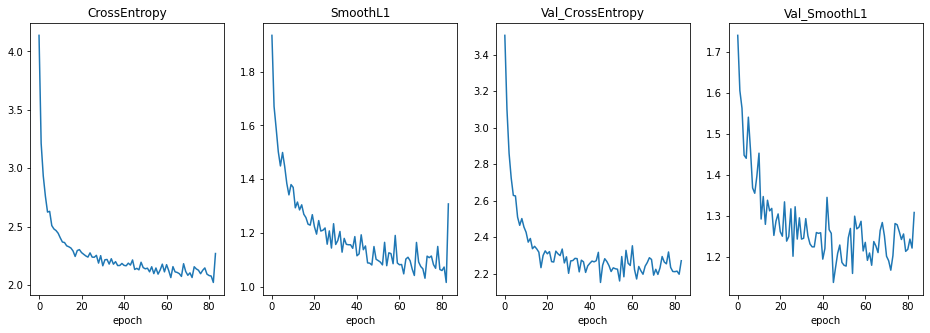

In [16]:
# Visualization
job_name = estimator.latest_training_job.job_name
df = TrainingJobAnalytics(job_name).dataframe()

metric_names = [d["Name"] for d in metric_definitions]
num_metrics = len(metric_names)

plt.figure(figsize=(16, 5))
for i in range(num_metrics):
    d = df[df["metric_name"] == metric_names[i]]
    plt.subplot(1, num_metrics, i + 1)
    plt.plot(range(len(d)), d["value"])
    plt.title(metric_names[i])
    plt.xlabel("epoch")
plt.show()

### Deployment

In [7]:
scope = "inference"
inference_instance_type = "ml.m4.xlarge"

# Retrieve inference docker image and inference script
deploy_script_uri = script_uris.retrieve(
    model_id=model_id, model_version=model_version, script_scope=scope
)
deploy_image_uri = image_uris.retrieve(
    region=None,
    framework=None,
    image_scope=scope,
    model_id=model_id,
    model_version=model_version,
    instance_type=inference_instance_type,
)

od_type2_endpoint_name = name_from_base("od-Type2")
print(od_type2_endpoint_name)

od_type2_predictor = estimator.deploy(
    initial_instance_count=1,
    instance_type=inference_instance_type,
    entry_point="inference.py",  # entry point file in source_dir and present in deploy_source_uri
    image_uri=deploy_image_uri,
    source_dir=deploy_script_uri,
    endpoint_name=od_type2_endpoint_name,
)

## 5. Training: Finetune Type 2 (Latest) OD model with HPO

The Type 2 (latest) OD model training reports Val_CrossEntropy loss and Val_SmoothL1 loss instead of mAP on the validation dataset. Since we can only specify one evaluation metric for AMT, we choose to minimize Val_CrossEntropy. It is not the standard practice for evaluating OD models, but is the best choice for now. 

In [ ]:
tuning_job_name = "od-Type2-HPO"

scope = "training"

objective_metric_name = "Val_CrossEntropy" if model_id.startswith("mxnet") else "val_loss"
hyperparameter_ranges = {
    "adam-learning-rate": ContinuousParameter(1e-4, 1e-1, scaling_type="Logarithmic"),
}

print("Train Type 2 (latest) OD model with HPO -------------------")

for training_instance_type in ["ml.p3.2xlarge", "ml.g4dn.xlarge", "ml.g5.xlarge", "ml.m5.2xlarge"]:
    try:
        train_image_uri = image_uris.retrieve(
            region=None,
            framework=None,
            image_scope=scope,
            model_id=model_id,
            model_version=model_version,
            instance_type=training_instance_type,
        )

        estimator = Estimator(
            role=role,
            image_uri=train_image_uri,
            source_dir=train_script_uri,
            model_uri=train_model_uri,
            entry_point="transfer_learning.py",
            hyperparameters=hyperparameters,
            instance_count=1,
            instance_type=training_instance_type,
            max_run=36000,
            output_path=s3_output_location,
            base_job_name=job_name_prefix,
            metric_definitions=metric_definitions,
        )

        tuner = HyperparameterTuner(
            estimator,
            objective_metric_name,
            hyperparameter_ranges,
            metric_definitions,
            objective_type="Minimize",
            max_jobs=max_jobs,
            max_parallel_jobs=max_parallel_jobs,  # <- increase this number if more EC2 instances are available
            base_tuning_job_name=tuning_job_name,
        )

        tuner.fit({"training": s3_input_train}, logs=True)

    except exceptions.CapacityError as e:
        print("Training exception:", e)
        print(f"{training_instance_type} is not available !!")
        continue
    except exceptions.UnexpectedStatusException as e:
        print("Training exception:", e)
        continue
    except ClientError as e:
        print("Training Exception:", e)
        continue
    else:
        print(f"Instance {training_instance_type} is available !")
        break

In [8]:
tuning_job_name = tuner.latest_tuning_job.name
print("tuning_job_name", tuning_job_name)

tuner_analytics = sagemaker.HyperparameterTuningJobAnalytics(tuning_job_name)

full_df = tuner_analytics.dataframe()

if len(full_df) > 0:
    df = full_df[full_df["FinalObjectiveValue"] > -float("inf")]
    if len(df) > 0:
        df = df.sort_values("FinalObjectiveValue", ascending=True)
        # filter out failed jobs.
        df = df[df["TrainingJobStatus"] == "Completed"]
        print(
            f"Number of training jobs completed and with valid objective: {len(df)} / {len(full_df)}"
        )
        print({"lowest": min(df["FinalObjectiveValue"]), "highest": max(df["FinalObjectiveValue"])})
        pd.set_option("display.max_colwidth", None)  # Don't truncate TrainingJobName
    else:
        print("No training jobs have reported valid results yet.")

df

best job: sagemaker-soln-dfd-c-220805-1125-003-3d4b78cc
best job final Val_CrossEntropy = 2.192000
All metrics: ['SmoothL1', 'Val_CrossEntropy', 'Val_SmoothL1', 'CrossEntropy', 'ObjectiveMetric']
ObjectiveMetric is exactly the same as Val_CrossEntropy


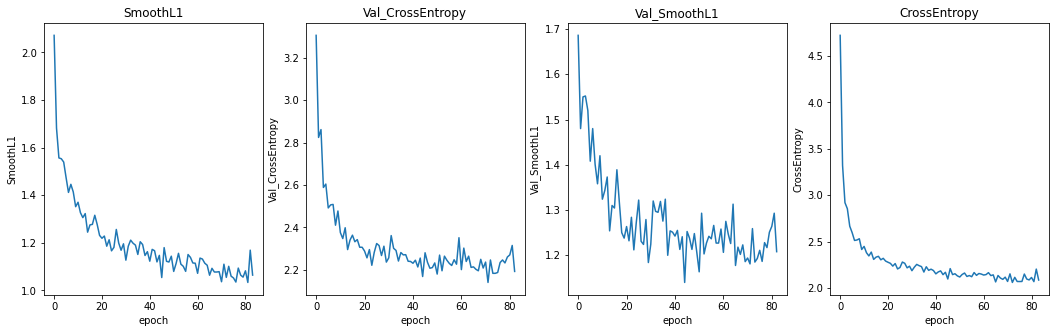

In [20]:
# Visualize the training progress of the best job
best_job_name = df.iloc[0]["TrainingJobName"]
print("best job:", best_job_name)
v = df.iloc[0]["FinalObjectiveValue"]
print(f"best job final Val_CrossEntropy = {v:.6f}")

df_best = TrainingJobAnalytics(best_job_name).dataframe()

OD_Type2_metrics = list(set(df_best.metric_name.values))
print("All metrics:", OD_Type2_metrics)
print("ObjectiveMetric is exactly the same as Val_CrossEntropy")
num_metrics = len(OD_Type2_metrics)

plt.figure(figsize=(18, 5))
cnt = 1
for m in OD_Type2_metrics:
    if m != "ObjectiveMetric":

        d = df_best[df_best["metric_name"] == m]

        plt.subplot(1, num_metrics - 1, cnt)
        plt.plot(range(len(d["value"])), d["value"])
        plt.title(m)
        plt.xlabel("epoch")
        plt.ylabel(m)
        cnt += 1
plt.show()

In [9]:
scope = "inference"
inference_instance_type = "ml.m4.xlarge"

od_type2_hpo_endpoint_name = name_from_base(f"od-Type2-HPO-{model_id}")
print(od_type2_hpo_endpoint_name)

od_type2_hpo_predictor = tuner.deploy(
    initial_instance_count=1,
    instance_type=inference_instance_type,
    entry_point="inference.py",  # entry point file in source_dir and present in deploy_source_uri
    image_uri=deploy_image_uri,
    source_dir=deploy_script_uri,
    endpoint_name=od_type2_hpo_endpoint_name,
)

## 6. Inference and Model Comparison

We compare model performance both visually and numerically. 
1. Visually, we sample images from the test data, one image from each category, and show the predicted bounding boxes, their predicted categories, and the confidence scores.
2. Numerically, we compute mAP on the pre-allocated test data. This is a fair comparison because we use the same metric and evaluate on the same test data.

In [22]:
import matplotlib.patches as patches
from PIL import Image, ImageColor
from utils import query_Type2, query_Type1, plot_results

categories = {
    1: "crazing",
    2: "inclusion",
    3: "pitted_surface",
    4: "patches",
    5: "rolled-in_scale",
    6: "scratches",
}

# Obtain all images and their annotations info
with open("test_annotations.json", "r") as f:
    info = json.load(f)

# images = {image['file_name']: image['id'] for image in info['images']}
images = info["images"]
annotations = info["annotations"]

### Visual comparison


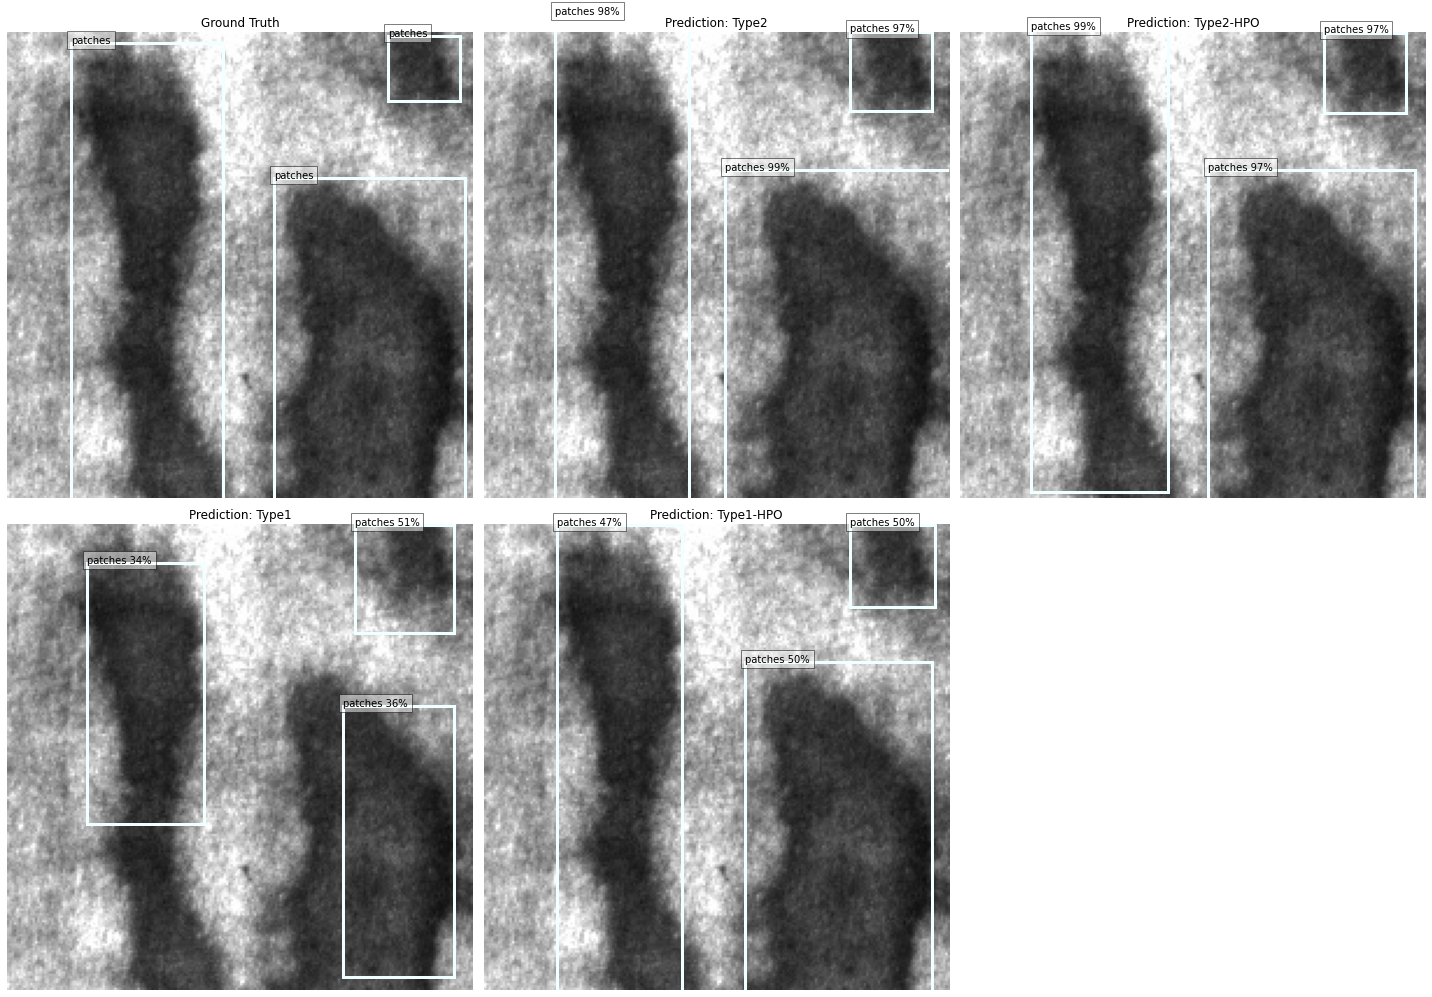

In [23]:
image_dir = "raw_neu_det/NEU-DET/IMAGES/"

image_name = "patches_116.jpg"
# image_name = "crazing_103.jpg"
# image_name = "inclusion_166.jpg"
# image_name = "pitted_surface_101.jpg"
# image_name = "rolled-in_scale_1.jpg"
# image_name = "scratches_158.jpg"

image = os.path.join(image_dir, image_name)


# Ground truth
image_info = [img for img in images if img["file_name"] == image_name][0]
bboxes = [a for a in annotations if a["image_id"] == image_info["id"]]

# dictionary of {endpoint_name_i: {'normalized_boxes': xxx, 'classes_names': yyy, 'confidences': zzz}, endpoint_name_2: {...}}
d = {}

# Inference. Could find all endpoints from Inference / Endpoints in the Sagemaker Dashboard
for endpoint_name in [
    od_type2_endpoint_name,
    od_type2_hpo_endpoint_name,
    od_type1_endpoint_name,
    od_type1_hpo_endpoint_name,
]:
    query_function = query_Type2 if "Type2" in endpoint_name else query_Type1
    normalized_boxes, classes_names, confidences = query_function(
        image, endpoint_name=endpoint_name, num_predictions=len(bboxes)
    )
    d[endpoint_name] = {
        "normalized_boxes": normalized_boxes,
        "classes_names": classes_names,
        "confidences": confidences,
    }

plot_results(image, bboxes, categories, d)

###  Numerical comparison


In [24]:
# 1. Convert test_annotations.json to the ground truth format that pycocotools can consume

from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval

annFile = "./test_annotations.json"
ground_truth_annFile = convert_to_pycocotools_ground_truth(annFile)

In [10]:
%%time
# 2. Use one endpoint to predict all test images
# run the following two cells for all endpoints

endpoint_name = od_type1_endpoint_name
# endpoint_name = od_type1_hpo_endpoint_name
# endpoint_name = od_type2_endpoint_name
# endpoint_name = od_type2_hpo_endpoint_name
# endpoint_name = 'sagemaker-soln-...-finetuned-endpoint'  # DDN model

print("endpoint: ", endpoint_name)

if "Type2" in endpoint_name:
    query_function = query_Type2
    output_file = (
        "results/type2_results.json"
        if endpoint_name == od_type2_endpoint_name
        else "results/type2_hpo_results.json"
    )
elif "Type1" in endpoint_name:
    query_function = query_Type1
    output_file = (
        "results/type1_results.json"
        if endpoint_name == od_type1_endpoint_name
        else "results/type1_hpo_results.json"
    )
else:
    ValueError("Un-recognized endpoint")
print("output file:", output_file)

coco_results = []

for i, img in enumerate(images):

    if i % 50 == 0:
        print(f"{i} / {len(images)} done")

    image_name = img["file_name"]
    image = os.path.join(image_dir, image_name)

    prediction_boxes, classes_names, confidences = query_function(
        image, endpoint_name=endpoint_name, num_predictions=100
    )

    # Rescale to original size for each bbox
    image_info = [img for img in images if img["file_name"] == image_name][0]
    W, H = image_info["width"], image_info["height"]

    prediction_boxes = [
        [xmin * W, ymin * H, (xmax - xmin) * W, (ymax - ymin) * H]
        for (xmin, ymin, xmax, ymax) in prediction_boxes
    ]

    coco_results.extend(
        [
            {
                "image_id": img["id"],
                "category_id": classes_names[k],
                "bbox": box,
                "score": confidences[k],
            }
            for k, box in enumerate(prediction_boxes)
        ]
    )

print(f"Total predictions for {len(images)} images:", len(coco_results))

jsonString = json.dumps(coco_results)
with open(output_file, "w") as f:
    f.write(jsonString)

In [11]:
# 3. Calculate mean Average Precision (mAP) on the test data
# CoCoeval reports a table of metric values, use the first row result to compare models

cocoGt = COCO(ground_truth_annFile)
cocoDt = cocoGt.loadRes(output_file)
cocoEval = COCOeval(cocoGt, cocoDt, "bbox")

imgIds = sorted(cocoGt.getImgIds())
cocoEval.params.imgIds = imgIds

cocoEval.evaluate()
cocoEval.accumulate()
cocoEval.summarize()

<!-- ![Numerical comparison!](./numerical.png "Numerical comparison") -->
<img src="./numerical.png" alt="drawing" width="800"/>

If you predict all test images using all endpoints, you end up with this table. The pycocotools package reports more metric values. We wil focus on row 1 - the mAP averaged over all IoU thresholds, all recall thresholds, all region sizes (small, medium, large), and all numbers of predicted bbox (1, 10, and 100), and all object categories. It's the [standard practice](https://cocodataset.org/#detection-eval) to use this metric for evaluating object detection algorithms.

### 7. Clean Up the Endpoints

When you are done with the endpoint, you should clean it up.

All of the training jobs, models and endpoints we created can be viewed through the SageMaker console of your AWS account.

In [27]:
# Delete the SageMaker endpoint
od_type1_predictor.delete_model()
od_type1_predictor.delete_endpoint()

od_type1_hpo_predictor.delete_model()
od_type1_hpo_predictor.delete_endpoint()

od_type2_predictor.delete_model()
od_type2_predictor.delete_endpoint()

od_type2_hpo_predictor.delete_model()
od_type2_hpo_predictor.delete_endpoint()

# You should go to the Sagemaker console and manually delete the DDN model endpoint

## 8. Conclusion

Both visual and numerical comparison confirm that the Type 2 (latest) OD model or Type 2 (latest) OD + HPO performs the best. 

1. Training models from scratch can be very time-consuming and less effective. In this example, the target dataset is very small, consisting of only 1,800 images in 6 categories, and the training data is only 64% of this small dataset.
2. The built-in Sagemaker OD models were pre-trained on large-scale dataset, e.g., the ImageNet dataset includes 14,197,122 images for 21,841 categories, and the PASCAL VOC dataset includes 11,530 images for 20 categories. The pre-trained models have learned rich and diverse low level features, and can efficiently transfer knowledge to finetuned models and focus on learning high-level semantic features for the target dataset.
3. HPO is extremely effective, especially for models with large hyperparameter search spaces. Since we finetuned on three hyperparameters (learning rate, momentum, and weight decay) for the Type 1 (legacy) OD models and only one hyperparameter (adam learning rate) for the Type 2 (latest) OD model, there is relatively larger room for improvement for the Type 1 (legacy) OD model and we do observe larger performance enhancement. Of course, we need to trade off model performance with budget (compute resource and training time) when running HPO.
4. In terms of training time, for the steel surface dataset, training the Type 1 (legacy) OD model took 34 min, Type 2 (latest) OD model took 1 hour, and the model trained from scratch took 8+ hours. It indicates finetuning a pre-trained model is much more efficient.
5. In summary, finetuning a pretrained model is both more efficient and more performant, we suggest taking advantage of the pre-trained Sagemaker built-in models and finetune on your target datasets.
